## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

from sklearn.base import BaseEstimator, ClassifierMixin

import sys
import numpy 
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import clone, metrics
#import graphviz 
from IPython.display import Image 
#import pydotplus
import sklearn.model_selection 
from sklearn import tree # decision Tree 
from sklearn.svm import SVR
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import  BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.spatial import distance
from sklearn import linear_model
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_squared_error, r2_score
import math
import random
import ipdb
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [2]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    '''
    SuperLearnerClassifier an Ensembel  super learner class to  classfiy Data Set on given models .
    Methods :
    
    self           :Classifier Object  
    distance_metric:  Distanc metrics 'euclidean',
    addDescFeature : This flag  Allows used to  add original Description Features to the Satcklayer Input
    basemodels     : An Array  of BaseClassifiers 
    isProbPred[True,False] : This Flag allows whether to do prediction based on  Probablity  or Normal in Predict Method 
    classes        :Number of Target classes
    cvfold         : Provide No  of Folds for K-Fold vlaidation
    n_estimators   : Give user To  choose no  of estimator instances of particular classifier
    stackLayer     : This Parameter allows user to give Classifier of his choice to Stack Layer .
                    Default is DecisionTreeClassifier()
                    Example: 
                    stackLayer=LogisticRegression()
    

    
    '''
    
   # Constructor for the classifier object
    def __init__(self, distance_metric = 'euclidean',addDescFeature=False,basemodels=[],isProbPred=False,classes=10,cvfold=10,n_estimators=6,stackLayer=DecisionTreeClassifier()):
        self.classes = classes
        self.distance_metric = distance_metric
        self.cvfold = cvfold
        self.n_estimators=n_estimators
        self.basemodels=basemodels
        self.sldata=pd.DataFrame()
        self.predDataFrame=pd.DataFrame()
        self.stackLayer=stackLayer
        self.isProbPred=isProbPred
        self.addDescFeature=addDescFeature
        
    
    
    def fit(self, X, Y):
        
        '''    
        Fit: Method used to Fit model Using Traininf Data
        Inputs:
        Self: clasifier Object
        X : Training Sample Data
        Y : Target Classes 
        Output :
        Trained Class Objects 
        '''
        lblDataFrame=pd.DataFrame()
        models = []
        modArray=self.basemodels
        
        if len(self.basemodels)==0:
            '''Condition where if user doesnot provide base models Superlernier has its ows perdefined Base models '''
            models.append(KNeighborsClassifier(n_neighbors=3))
            models.append(LogisticRegression())
            models.append(KNeighborsClassifier(n_neighbors=3))
            models.append(RandomForestClassifier())
            models.append(AdaBoostClassifier())
            models.append(GaussianNB())
            self.basemodels=models
               
        self.n_estimators=len(models)
        self.classes_ = unique_labels(Y)
        
        results = pd.DataFrame()
        names = []        
        kf = KFold(n_splits=self.cvfold) # Define the split - into userdefined folds folds         
        if isinstance(X, type(pd.DataFrame())) or isinstance(X, type(pd.DataFrame())):
            xvalue=X.values
            yvalue=Y.values
        else:
            xvalue=X
            yvalue=Y
        finalProbaArray=np.array([])
        finalTargetArray=np.array([])    
        finalDF=pd.DataFrame()
        #Kfold Crossvalidation On Traindata  
        for train_index, test_index in kf.split(xvalue):
            X_train, X_test=xvalue[train_index], xvalue[test_index]
            y_train, y_test=yvalue[train_index],yvalue[test_index]            
            counter=1                
            if self.isProbPred==False:
                dFramePredict = pd.DataFrame()
                for baseMod in self.basemodels:
                    baseMod.fit(X_train,y_train)
                    modelname='Model' + str(counter)
                    counter+=1
                    dFramePredict[modelname]=baseMod.predict(X_test)             
                    
                
            else:
                oDataFrame=[]
                for baseMod in self.basemodels:
                    baseMod.fit(X_train,y_train)
                    modelname='Model' + str(counter)
                    values=pd.DataFrame(baseMod.predict_proba(X_test), columns= ['a' +str(i) for i in range(counter,counter+10)]) 
                    oDataFrame.append(values)                     
                    counter=counter+10
                dFramePredict=pd.concat(oDataFrame,axis=1)
            
            
            if self.addDescFeature==True:
                
                XdataFrame=pd.DataFrame(X_test)
                featureDataFrame=pd.DataFrame(X_test,columns=XdataFrame.columns.values)                
                
                featureDataFrame=featureDataFrame.reset_index(drop=True)
                                
                dFramePredict=pd.concat([dFramePredict,featureDataFrame],axis=1)

            
             
            finalDF=pd.concat([finalDF,dFramePredict])
            finalDF.reset_index(drop=True)
            finalTargetArray=np.append(finalTargetArray,y_test)
            
        self.stackLayer.fit(finalDF, finalTargetArray)               
            
        return self
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        '''
            
        Predict Method: Method used to predict labels of test data
        Inputs: 
        X : Test  Sample Data
         
        Output :
        array of Labels
        '''
        
        dFramePredict = pd.DataFrame()
        if self.isProbPred==False:
            counter=1
            for baseMod in self.basemodels:
                modelname='Model' + str(counter)
                dFramePredict[modelname]=baseMod.predict(X)
                counter+=1              
                
        else:
            oDataFrame=[]
            counter=0
            
            for baseMod in self.basemodels:
                values=pd.DataFrame(baseMod.predict_proba(X), columns= ['a' +str(i) for i in range(counter,counter+10)]) 
                oDataFrame.append(values)                     
                counter=counter+10
               
            #dFramePredict=pd.concat([dFramePredict,oDataFrame],axis=0)
            dFramePredict=pd.concat(oDataFrame,axis=1)
        
        if self.addDescFeature==True:
            XdataFrame=pd.DataFrame(X_test)
            featureDataFrame=pd.DataFrame(X_test,columns=XdataFrame.columns.values)                
            featureDataFrame=featureDataFrame.reset_index(drop=True)                               
            dFramePredict=pd.concat([dFramePredict,featureDataFrame],axis=1)
        
        predDataFrame=pd.DataFrame()    
        predDataFrame=pd.concat([predDataFrame,dFramePredict])
        
        labels= self.stackLayer.predict(predDataFrame)
        return labels
    
    def estimatorCorrelation(self,estimators=[]):
        '''
        estimatorCorrelation : 
        This Method IS used to  find Corelation  between the BAse models.
        which  shows the user to  correlation among the ensembel
        
        Parameter:
        estimators : array of list of estimaters 
        
        '''
        models=[]
        ClassifierPredictions=pd.DataFrame()
        accuracyDataFrame=pd.DataFrame()
        accuracyArray=[]
        
        if len(estimators)==0:
            
            models=self.basemodels
            #ClassifierPredictions=self.sldata
            count=1
            
            for  mod in models:
                modName='Model'+str(count)
                mod.fit(X_train,y_train)
                y_predvalue=mod.predict(X_test)
                ClassifierPredictions[modName]=y_predvalue
                accuracyArray=np.array(metrics.accuracy_score(y_test, y_predvalue)) 
                count+=1    
        else:
            
            models=estimators
            count=1
            
            for  mod in models:
                modName='Model'+str(count)
                mod.fit(X_train,y_train)
                y_predvalue=mod.predict(X_test)
                ClassifierPredictions[modName]=mod.predict(X_test)
                accuracyArray=np.array(metrics.accuracy_score(y_test, y_predvalue)) 
                count+=1    
        
        oSuperLearner=SuperLearnerClassifier(models)
        oSuperLearner.fit(X_train,y_train)
        y_pred=oSuperLearner.predict(X_test)
        SLPrediction=pd.DataFrame()
        SLPrediction['SLearn']=y_pred.astype(int)
        accuracyDataFrame['SLearn']=metrics.accuracy_score(y_test, y_pred)

        ClassifierPredictions=pd.concat([ClassifierPredictions,SLPrediction],axis=1) 
        Classifiercorrelation = ClassifierPredictions.corr()
        grid = sns.PairGrid(Classifiercorrelation)
        grid.map(plt.scatter)
        print("=========Accuracy====================")
        print(accuracyArray)

    
        def predictProb(self, X):
            print('PredictProb')
            predDataFrame=pd.DataFrame()
            counter=1
            if self.isProbPred==False:
                    dFramePredict = pd.DataFrame()
                    for baseMod in self.basemodels:

                        modelname='Model' + str(counter)
                        dFramePredict[modelname]=baseMod.predict(X)
                        counter+=1              
                        
            else:
                oDataFrame=[]
                for baseMod in self.basemodels:
                    values=pd.DataFrame(baseMod.predict_proba(X), columns= ['a' +str(i) for i in range(counter,counter+10)]) 
                    oDataFrame.append(values)                     
                    counter=counter+10
                dFramePredict=pd.concat(oDataFrame,axis=1)
            
            if self.addDescFeature==True:
                
                XdataFrame=pd.DataFrame(X)
                featureDataFrame=pd.DataFrame(X,columns=XdataFrame.columns.values)                
                
                featureDataFrame=featureDataFrame.reset_index(drop=True)
                
                dFramePredict=pd.concat([dFramePredict,featureDataFrame],axis=1)
            
            predDataFrame=pd.concat([predDataFrame,dFramePredict])
            
            labels=[]
            if self.addDescFeature==True:
                
                featureDataFrame=pd.DataFrame()
                XvalueTemp=pd.DataFrame(X)
                featureDataFrame=pd.concat([predDataFrame,X])
                
                labels= self.stackLayer.predict(featureDataFrame)
            else:
                labels= self.stackLayer.predict(predDataFrame)
                
            self.sldata=self.predDataFrame    

            return labels
        
            
            

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [3]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                from sklearn.datasets import load_iris
clf = SuperLearnerClassifier()
iris = load_iris()

X_train, X_test, y_train, y_test \
    = train_test_split(iris.data, iris.target, random_state=0, \
                                    train_size = 0.8)
clf.fit(X_train, y_train)
clf.predict(X_test)

array([2., 1., 0., 2., 0., 2., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 1., 0.])

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [4]:
data_sampling_rate = 0.01

Setup the number of folds for all grid searches (should be 5 - 10)

In [5]:
cv_folds = 5

### Load Dataset

Load the dataset and explore it.

In [6]:
dataset = pd.read_csv('.\\fashionmnist\\fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
54603,0,0,0,3,0,0,0,0,0,64,...,198,214,30,0,2,0,0,0,0,0
47767,1,0,0,0,0,0,0,0,0,0,...,128,0,0,0,0,0,0,0,0,0
25753,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54264,0,0,0,0,0,0,0,0,0,0,...,64,22,57,22,0,1,0,0,0,0
13540,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [7]:
# Add code here
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])
X = np.array(X/255)  
X_train, X_test, y_train, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.8)    

## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [8]:

clf = SuperLearnerClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print('===Evaluating the trained classifier=====')
accuracy = metrics.accuracy_score(y_test,y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))


===Evaluating the trained classifier=====
Accuracy: 0.725


Evaluate the trained classifier

In [9]:
# Add code here
clf=SuperLearnerClassifier()
clf.fit(X,Y)
y_pred=clf.predict(X_test)
print('===Evaluating the trained classifier=====')
accuracy = metrics.accuracy_score(y_test,y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))

print("====Linear Regression==")
Linearclf=SuperLearnerClassifier(stackLayer=linear_model.LinearRegression())
Linearclf.fit(X,Y)
y_linearPred=Linearclf.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f", mean_squared_error(y_test,y_linearPred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test,y_linearPred))





===Evaluating the trained classifier=====
Accuracy: 0.875
====Linear Regression==
Mean squared error: %.2f 0.23844574942062782
Variance score: 0.97


## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [10]:
clf = SuperLearnerClassifier()
clf.fit(X_train,y_train)
print(cross_val_score(clf, X_train, y_train,cv=10))


[0.71153846 0.74509804 0.74509804 0.7254902  0.69387755 0.625
 0.70212766 0.73913043 0.6744186  0.71428571]


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

In [16]:
# Add code here

print('===Evaluating the Predefined classifier=====')

clf = SuperLearnerClassifier()
clf.fit(X,Y)
y_pred=clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))

print('===Evaluating the User Defined classifier=====')

models = [KNeighborsClassifier(n_neighbors=3),LogisticRegression(),RandomForestClassifier()]
clf = SuperLearnerClassifier(basemodels=models)
clf.fit(X,Y)
y_pred=clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred) 
print("Accuracy: " +  str(accuracy))

print('===Evaluating the isProbPred False, LogisticRegression() classifier=====')

clfPredisProb = SuperLearnerClassifier(isProbPred=False,stackLayer=LogisticRegression())
clfPredisProb.fit(X, Y)
y_pred=clfPredisProb.predict(X_test)
print('===Evaluating the isProbPred classifier=====')
accuracy = metrics.accuracy_score(y_test,y_pred) 
print("Accuracy : " +  str(accuracy))

print('===Evaluating the isProbPred true by default decision tree as stacklayer classifier =====')
clfPredisProbT = SuperLearnerClassifier(isProbPred=True)
clfPredisProbT.fit(X, Y)
y_pred=clfPredisProbT.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred) 
print("Accuracy : " +  str(accuracy))

print('===Evaluating the isProbPred true, LogisticRegression() classifier=====')

clfPredLogistic = SuperLearnerClassifier(isProbPred=True,stackLayer=LogisticRegression())
clfPredLogistic.fit(X, Y)
y_pred=clfPredLogistic.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred) 
print("Accuracy : " +  str(accuracy))

===Evaluating the Predefined classifier=====
Accuracy: 0.8833333333333333
===Evaluating the User Defined classifier=====
Accuracy: 0.9666666666666667
===Evaluating the isProbPred False, LogisticRegression() classifier=====
===Evaluating the isProbPred classifier=====
Accuracy : 0.5583333333333333
===Evaluating the isProbPred true by default decision tree as stacklayer classifier =====
Accuracy : 0.9583333333333334
===Evaluating the isProbPred true, LogisticRegression() classifier=====
Accuracy : 0.9666666666666667


## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

In [12]:
KNN=KNeighborsClassifier(n_neighbors=3)
LR= LogisticRegression()
CART= DecisionTreeClassifier()

param_grid = [{'basemodels': [[KNN,LR,CART]]},{'stackLayer': [linear_model.LogisticRegression()]},
              {'isProbPred': [False]}]


slearnclf = SuperLearnerClassifier(basemodels=[KNN,LR,CART])
slearnclf.fit(X,Y)
clf = GridSearchCV(slearnclf,param_grid)
clf.fit(X, Y)


GridSearchCV(cv=None, error_score='raise',
       estimator=SuperLearnerClassifier(addDescFeature=False,
            basemodels=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), LogisticRegression(C=1.0, class_weight=None, dual=False,...lit=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'basemodels': [[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1..., solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)]}, {'isProbPred': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [13]:
# Add code here
#Make a set of predictions for the test data
y_pred = clf.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9666666666666667
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      0.93      0.96        14
          2       0.90      1.00      0.95         9
          3       0.94      1.00      0.97        15
          4       1.00      0.83      0.91         6
          5       1.00      1.00      1.00        17
          6       0.87      1.00      0.93        13
          7       1.00      1.00      1.00        11
          8       1.00      0.83      0.91        12
          9       1.00      1.00      1.00        12

avg / total       0.97      0.97      0.97       120

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,11,0,0,0,0,0,0,0,0,0,11
1,0,13,0,1,0,0,0,0,0,0,14
2,0,0,9,0,0,0,0,0,0,0,9
3,0,0,0,15,0,0,0,0,0,0,15
4,0,0,1,0,5,0,0,0,0,0,6
5,0,0,0,0,0,17,0,0,0,0,17
6,0,0,0,0,0,0,13,0,0,0,13
7,0,0,0,0,0,0,0,11,0,0,11
8,0,0,0,0,0,0,2,0,10,0,12


## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

In [14]:
# Add code here
originalSuperLearner=SuperLearnerClassifier(addDescFeature=True)
originalSuperLearner.fit(X_train,y_train)
y_pred = originalSuperLearner.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7083333333333334
             precision    recall  f1-score   support

          0       0.75      0.82      0.78        11
          1       1.00      0.86      0.92        14
          2       0.56      0.56      0.56         9
          3       0.87      0.87      0.87        15
          4       0.38      0.50      0.43         6
          5       0.76      0.76      0.76        17
          6       0.38      0.38      0.38        13
          7       0.60      0.27      0.37        11
          8       1.00      0.83      0.91        12
          9       0.63      1.00      0.77        12

avg / total       0.72      0.71      0.70       120

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,9,0,0,0,1,0,1,0,0,0,11
1,0,12,0,2,0,0,0,0,0,0,14
2,0,0,5,0,1,1,2,0,0,0,9
3,0,0,0,13,1,0,1,0,0,0,15
4,0,0,1,0,3,0,2,0,0,0,6
5,0,0,0,0,0,13,1,2,0,1,17
6,3,0,3,0,2,0,5,0,0,0,13
7,0,0,0,0,0,2,0,3,0,6,11
8,0,0,0,0,0,1,1,0,10,0,12


## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

=========Accuracy====================
0.5333333333333333


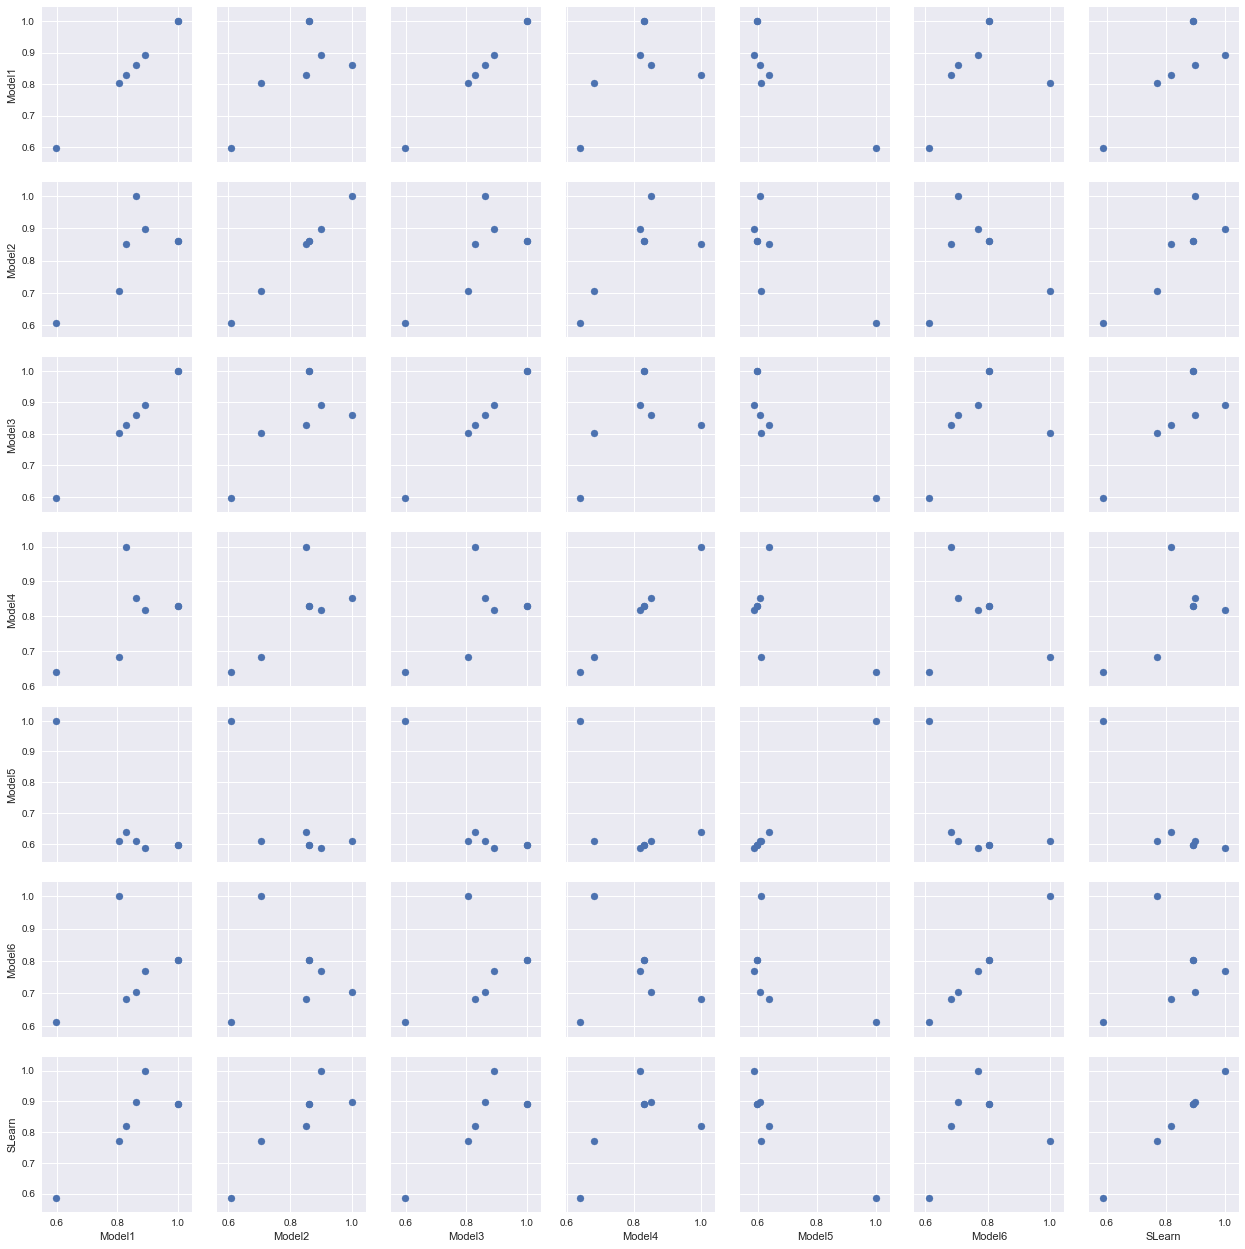

In [15]:
oSuperLearner=SuperLearnerClassifier()
oSuperLearner.fit(X_train,y_train)
oSuperLearner.estimatorCorrelation()